# Implémentez un modèle de scoring

## Sommaire

## Mise en place technique

In [1]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import missingno as msno
from importlib.metadata import version
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from scipy.stats import randint as sp_randint
import nltk
import tensorflow as tf

## Analyse de données et feature engeniering

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    new_n_list = list(new_names.values())
    # [LightGBM] Feature appears more than one time.
    new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
    df = df.rename(columns=new_names)
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            early_stopping_rounds= 200)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
  #  with timer("Run LightGBM with kfold"):
     #   feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug) 
    return df    

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        data = main() 

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 33s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s
Full model run - done in 124s


In [3]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.duplicated('SK_ID_CURR').sum()

0

In [5]:
data.describe()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,103558.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,103558.0,103558.0,102866.0,103558.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,0.047597,0.003583,0.106781,0.002955,0.0,0.0,0.0,0.0,0.0,37.083683
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,0.212912,0.031014,1.272522,0.019938,0.0,0.0,0.0,0.0,0.0,33.483627
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.000000
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,22.000000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,75.000000
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,1.000000,1.000000,62.000000,0.500000,0.0,0.0,0.0,0.0,0.0,192.000000


In [6]:
data.isna().mean()

index                               0.000000
SK_ID_CURR                          0.000000
TARGET                              0.136825
CODE_GENDER                         0.000000
FLAG_OWN_CAR                        0.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.709312
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.709312
CC_NAME_CONTRACT_STATUS_nan_SUM     0.709312
CC_NAME_CONTRACT_STATUS_nan_VAR     0.711254
CC_COUNT                            0.709312
Length: 798, dtype: float64

In [7]:
def missing_values_imputation(df):
    for v in df.columns:
        #if (df[v].dtypes == 'float64' or df[v].dtypes == 'int64'): 
        median=df[v].median()
        df[v].fillna(median, inplace=True)
    
    print("Done : 100% \n")


In [8]:
print("removing empty columns > 50% :")
print("=============================")
# removing empty columns > 50%
data = data.loc[:, data.isnull().mean() <.50]
print("Done : 100%")

removing empty columns > 50% :
Done : 100%


In [9]:
#data = data.sample(frac = 0.1, random_state = 42)

In [10]:

# replace infinity values by "nan"
data.replace([np.inf, -np.inf], np.nan, inplace=True)
        
# missing_values_imputation    
print("Missing values imputation processing :")
missing_values_imputation(data)


C:\Users\WILSON\AppData\Local\Temp\ipykernel_8240\1097090998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\WILSON\AppData\Local\Temp\ipykernel_8240\2044391541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[v].fillna(median, inplace=True)


Missing values imputation processing :


C:\Users\WILSON\AppData\Local\Temp\ipykernel_8240\2044391541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[v].fillna(median, inplace=True)
C:\Users\WILSON\AppData\Local\Temp\ipykernel_8240\2044391541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[v].fillna(median, inplace=True)
C:\Users\WILSON\AppData\Local\Temp\ipykernel_8240\2044391541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[v].fillna(median, inplace=T

Done : 100% 



In [11]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,0.0,1,0,0,0,121500.0,412560.0,17473.5,...,91036.455000,273109.365,14222.430,244664.505,91036.455000,273109.365,-599.0,-630.333333,-1891.0,3.0
356251,48740,456222,0.0,1,0,1,2,157500.0,622413.0,31909.5,...,8086.162192,590289.840,2.700,14571.765,7771.447603,567315.675,-56.0,-992.712329,-72468.0,73.0
356252,48741,456223,0.0,1,1,0,1,202500.0,315000.0,33205.5,...,23158.991250,185271.930,12640.950,81184.005,23158.991250,185271.930,-33.0,-586.375000,-4691.0,8.0
356253,48742,456224,0.0,0,0,1,0,225000.0,450000.0,25128.0,...,17269.234138,500807.790,5519.925,23451.705,17269.234138,500807.790,-13.0,-924.965517,-26824.0,29.0


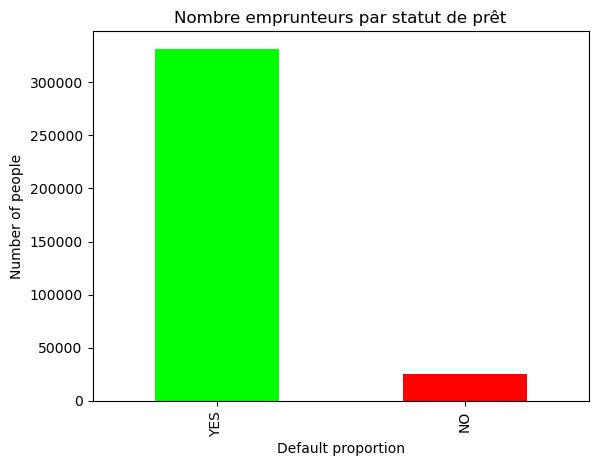

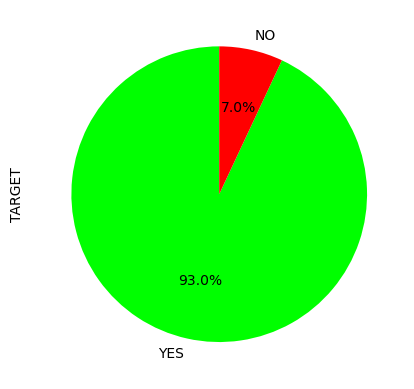

In [12]:
# Affichage Graphique du déséquilibre des classes   
df = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET']
X_id=df['SK_ID_CURR']

import joblib
# Sauvegarde du modèle
joblib.dump(id, 'id.pkl')

X= df.drop(['index','TARGET', 'SK_ID_CURR'],axis=1)
y.replace(to_replace=[0,1], value= ['YES','NO'], inplace = True)
fig11=plt.figure()
ax11=plt.axes()
colors = ['#00FF00','#FF0000']
plt.title('Nombre emprunteurs par statut de prêt')
ax11 = ax11.set(xlabel='Default proportion', ylabel='Number of people')   
y.value_counts().plot.bar(color=colors)
fig12=plt.figure()
ax12=plt.axes()    
y.value_counts().plot.pie(startangle=90, autopct='%1.1f%%',colors=colors )
plt.show()

Utilisation de Oversample with SMOTE and random undersample for imbalanced dataset

Counter({'YES': 331426, 'NO': 24825})
Counter({0.0: 220950, 1.0: 132570})


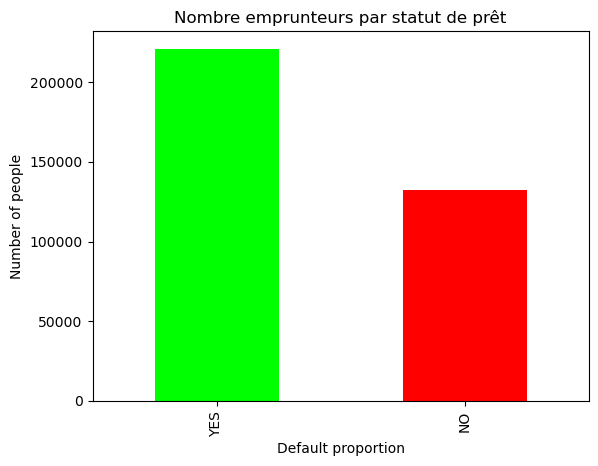

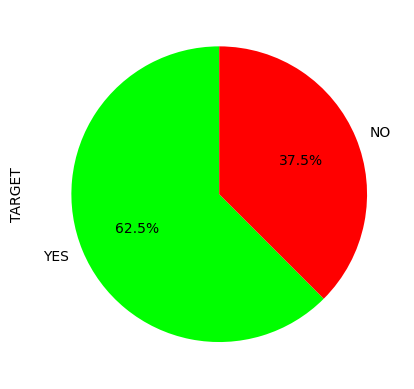

In [13]:

# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# summarize class distribution
counter = Counter(y)
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
#steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
y = data['TARGET']
X = data.drop(['index','TARGET', 'SK_ID_CURR'],axis=1)
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
y.replace(to_replace=[0,1], value= ['YES','NO'], inplace = True)
fig11=plt.figure()
ax11=plt.axes()
colors = ['#00FF00','#FF0000']
plt.title('Nombre emprunteurs par statut de prêt')
ax11 = ax11.set(xlabel='Default proportion', ylabel='Number of people')   
y.value_counts().plot.bar(color=colors)
fig12=plt.figure()
ax12=plt.axes()    
y.value_counts().plot.pie(startangle=90, autopct='%1.1f%%',colors=colors )
plt.show()

In [14]:
y.replace(to_replace=['YES','NO'], value=[1,0] , inplace = True)
y

0         1
1         1
2         1
3         1
4         1
         ..
353515    0
353516    0
353517    0
353518    0
353519    0
Name: TARGET, Length: 353520, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Création du score métier et le seuil de solvabilité

In [16]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
def score_metier(y, y_pos_prob, threshold):
    y_pred = y_pos_prob < threshold
        
    mat_conf = confusion_matrix(y, y_pred)
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    print(threshold)
    print((10*fn) + 1*fp)
    return ((10*fn) + 1*fp)
my_scorer = make_scorer(score_metier, needs_proba=True,threshold=0.5 ,greater_is_better = False)

## Mise en place de MLflow

In [17]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


import logging
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    def eval_metrics(actual, pred):
        auc = roc_auc_score(actual, pred)
        accuracy = accuracy_score(actual, pred)
        return auc, accuracy

    mlflow.set_experiment("model_dummy")
    mlflow.sklearn.autolog()
    strategy= ['stratified', 'most_frequent', 'uniform']
    with mlflow.start_run(run_name = 'Dummy_clf'):
        param_grid={'strategy': ['stratified', 'most_frequent', 'uniform']}
        dummy_clf = DummyClassifier()
        grid_dummy = GridSearchCV(dummy_clf, param_grid, scoring = my_scorer)
        grid_dummy.fit(X_train, y_train)

        predicted = grid_dummy.predict(X_test)

        (auc, accuracy) = eval_metrics(y_test, predicted)
        print('best estimator :',grid_dummy.best_estimator_)
        print('score metier :', grid_dummy.best_score_)

        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("score metier", grid_dummy.best_score_)



0.5
200658
0.5
200889
0.5
200381
0.5
199428
0.5
200338
0.5
309210
0.5
309220
0.5
309220
0.5
309220
0.5
309210
0.5
309210
0.5
309220
0.5
309220
0.5
309220
0.5
309210
0.5
1000332


2023/10/20 21:38:24 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : DummyClassifier(strategy='stratified')
score metier : -200338.8


In [18]:
mlflow.set_experiment("logistic_regression")
with mlflow.start_run(run_name = 'logistic_reg'):
    LOGREG_rand_params= [{'max_iter':[100, 200,1000],
                      'C': [0.1, 1, 10],
                      'class_weight': [{0:1, 1:20}]   # 13=>0.38 ; 20=> 0.44      
                     }]
    LOGREG = LogisticRegression()
    grid2 = GridSearchCV(LOGREG, LOGREG_rand_params ,cv = 3, refit = True, verbose = 3, scoring = my_scorer)
    grid2.fit(X_train, y_train)

    predicted3 = grid2.predict(X_test)

    (auc, accuracy) = eval_metrics(y_test, predicted3)
    print('best estimator :',grid2.best_estimator_)
    print('score metier :', grid2.best_score_)
    #mlflow.log_param("C", C)
    #mlflow.log_param("max_iter", max_iter)
    #mlflow.log_param("class_weight", class_weight)
    mlflow.log_metric("accuracy",accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("score metier", grid2.best_score_)
    

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.5
515212
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=100;, score=-515212.000 total time=  14.5s
0.5
515332
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=100;, score=-515332.000 total time=  16.2s
0.5
515185
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=100;, score=-515185.000 total time=  14.2s
0.5
515312
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=200;, score=-515312.000 total time=  27.4s
0.5
515322
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=200;, score=-515322.000 total time=  26.5s
0.5
515321
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=200;, score=-515321.000 total time=  25.1s
0.5
515243
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=1000;, score=-515243.000 total time=  37.1s
0.5
515351
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 20}, max_iter=1000;, score=-515351.000 total time= 1.1min
0.5
515272
[CV 3/3] END C=0.1, class_weight={0: 1,

2023/10/20 21:54:20 INFO mlflow.sklearn.utils: Logging the 5 best runs, 4 runs will be omitted.


best estimator : LogisticRegression(C=0.1, class_weight={0: 1, 1: 20})
score metier : -515243.0


In [19]:
from sklearn.ensemble import RandomForestClassifier
mlflow.set_experiment("RandomForestClassifier")
n_estimators=[100,500]
max_depth= [3,5,None]
max_features=[1,2,3]
criterion=['gini'] # ,'entropy'   # Cost function
bootstrap = [True,False]
min_samples_leaf=[1,2,3,4]
class_weight=[{0:1, 1:20}]
with mlflow.start_run(run_name = 'RandomForestClassifier'):
    RFC_rand_params= [{'n_estimators' :[100,500],
                   'max_depth':[3,5,None],
                   'max_features':[1,2,3],
                   'criterion':['gini'], # ,'entropy'   # Cost function
                   'bootstrap':[True,False],
                   'min_samples_leaf':[1,2,4],
                   'class_weight': [{0:1, 1:20}]
                  }]
    RFC_rand = RandomForestClassifier()
    grid3 = GridSearchCV(RFC_rand, RFC_rand_params ,cv = 3, refit = True, verbose = 3,scoring = my_scorer)
    grid3.fit(X_train, y_train)

    predicted4 = grid3.predict(X_test)

    (auc, accuracy) = eval_metrics(y_test, predicted4)
    print('best estimator :',grid3.best_estimator_)
    print('score metier :', grid3.best_score_)
    
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("bootstrap", bootstrap)
    mlflow.log_param("min_samples_leaf", min_samples_leaf)
    mlflow.log_param("class_weight", class_weight)
    mlflow.log_metric("accuracy",accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("score metier", grid3.best_score_)
    

Fitting 3 folds for each of 108 candidates, totalling 324 fits
0.5
515360
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   4.3s
0.5
515360
[CV 2/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   3.9s
0.5
515360
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   4.0s
0.5
515360
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=1, n_estimators=500;, score=-515360.000 total time=  17.4s
0.5
515360
[CV 2/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=1, n_estimators=500;, score=-515360.000 total time=

0.5
515360
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=3, min_samples_leaf=2, n_estimators=100;, score=-515360.000 total time=   6.2s
0.5
515360
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=3, min_samples_leaf=2, n_estimators=500;, score=-515360.000 total time=  28.1s
0.5
515360
[CV 2/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=3, min_samples_leaf=2, n_estimators=500;, score=-515360.000 total time=  27.6s
0.5
515360
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=3, min_samples_leaf=2, n_estimators=500;, score=-515360.000 total time=  27.9s
0.5
515360
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=3, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=   6.3s
0.5
515360
[CV 2/3] END bootstrap=True, class_weight={0

0.5
515360
[CV 2/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=2, min_samples_leaf=4, n_estimators=500;, score=-515360.000 total time=  31.5s
0.5
515360
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=2, min_samples_leaf=4, n_estimators=500;, score=-515360.000 total time=  31.4s
0.5
515360
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   8.7s
0.5
515360
[CV 2/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   8.9s
0.5
515360
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   8.7s
0.5
515360
[CV 1/3] END bootstrap=True, class_weight={0

0.5
537586
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=2, min_samples_leaf=1, n_estimators=500;, score=-537586.000 total time= 2.6min
0.5
519372
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=2, min_samples_leaf=2, n_estimators=100;, score=-519372.000 total time=  24.5s
0.5
519056
[CV 2/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=2, min_samples_leaf=2, n_estimators=100;, score=-519056.000 total time=  24.3s
0.5
519099
[CV 3/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=2, min_samples_leaf=2, n_estimators=100;, score=-519099.000 total time=  24.3s
0.5
519006
[CV 1/3] END bootstrap=True, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=2, min_samples_leaf=2, n_estimators=500;, score=-519006.000 total time= 2.0min
0.5
519035
[CV 2/3] END bootstrap=True, 

0.5
515360
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=   4.7s
0.5
515360
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=   4.4s
0.5
515360
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=   4.4s
0.5
515360
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=4, n_estimators=500;, score=-515360.000 total time=  19.3s
0.5
515360
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=3, max_features=1, min_samples_leaf=4, n_estimators=500;, score=-515360.000 total time=  19.3s
0.5
515360
[CV 3/3] END bootstrap=False, class_wei

0.5
515360
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=100;, score=-515360.000 total time=   6.0s
0.5
515360
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500;, score=-515360.000 total time=  27.8s
0.5
515360
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500;, score=-515360.000 total time=  27.3s
0.5
515360
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500;, score=-515360.000 total time=  27.2s
0.5
515360
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=1, min_samples_leaf=2, n_estimators=100;, score=-515360.000 total time=   6.0s
0.5
515360
[CV 2/3] END bootstrap=False, class_wei

0.5
515360
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=2, n_estimators=500;, score=-515360.000 total time=  58.0s
0.5
515360
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=2, n_estimators=500;, score=-515360.000 total time=  56.5s
0.5
515360
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=  11.8s
0.5
515360
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=  11.9s
0.5
515360
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=5, max_features=3, min_samples_leaf=4, n_estimators=100;, score=-515360.000 total time=  11.9s
0.5
515360
[CV 1/3] END bootstrap=False, class_wei

0.5
515408
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=2, min_samples_leaf=4, n_estimators=500;, score=-515408.000 total time= 2.5min
0.5
536408
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=3, min_samples_leaf=1, n_estimators=100;, score=-536408.000 total time=  56.7s
0.5
536063
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=3, min_samples_leaf=1, n_estimators=100;, score=-536063.000 total time=  56.2s
0.5
535993
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=3, min_samples_leaf=1, n_estimators=100;, score=-535993.000 total time=  57.1s
0.5
537766
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 20}, criterion=gini, max_depth=None, max_features=3, min_samples_leaf=1, n_estimators=500;, score=-537766.000 total time= 4.7min
0.5
537533
[CV 2/3] END bootstrap=F

2023/10/21 01:52:13 INFO mlflow.sklearn.utils: Logging the 5 best runs, 103 runs will be omitted.


best estimator : RandomForestClassifier(class_weight={0: 1, 1: 20}, max_depth=3, max_features=1)
score metier : -515360.0


In [20]:
nthread = [2,6]
n_estimators= [300,700,1000]
learning_rate = [0.02, 0.2]
num_leaves= [30,35]
max_depth= [5,10,15]
min_child_weight= [35,40]
scale_pos_weight= [25]
mlflow.set_experiment("LGBMClassifier")
with mlflow.start_run(run_name = 'LGBMClassifier'):
    LGBM_rand_params=[{'nthread':[2,6],
                   'n_estimators':[300,700,1000],
                   'learning_rate':[0.02,0.2],
                   'num_leaves':[30,35],
                   'max_depth':[10,15],
                   'min_child_weight':[35,40],
                   'scale_pos_weight': [25]}]
    LGBM_rand = LGBMClassifier()
    grid4 = GridSearchCV(LGBM_rand, LGBM_rand_params ,cv = 5, refit = True, verbose = 3, scoring = my_scorer)
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns}
    new_n_list = list(new_names.values())
    # [LightGBM] Feature appears more than one time.
    new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
    X_train = X_train.rename(columns=new_names)
    grid4.fit(X_train, y_train)

    predicted5 = grid4.predict(X_test)

    (auc, accuracy) = eval_metrics(y_test, predicted5)
    print('best estimator :',grid4.best_estimator_)
    print('score metier :', grid4.best_score_)

    mlflow.log_param("nthread", nthread)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_leaves", num_leaves)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("min_child_weight", min_child_weight)
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_metric("accuracy",accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("score metier", grid4.best_score_)
    

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
0.5
322842
[CV 1/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=300, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-322842.000 total time=  25.8s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
323039
[CV 3/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=300, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323039.000 total time=  24.7s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
0.5
324100
[CV 5/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=700, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-324100.000 total time=  53.0s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binar

0.5
324056
[CV 2/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=700, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324056.000 total time=  56.7s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324158
[CV 3/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=700, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324158.000 total time=  57.1s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324202
[CV 3/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=1000, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324202.000 total time= 1.3min
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324151
[CV 2/5] END learning_rate=0.02, max_depth=10, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324151.000 total time= 1.3min
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
323101
[CV 3/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323101.000 total time=  26.8s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
0.5
323027
[CV 5/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-323027.000 total time=  26.8s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.337010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binar

0.5
324060
[CV 2/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324060.000 total time=  52.8s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324149
[CV 3/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324149.000 total time=  52.9s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324189
[CV 4/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-324189.000 total time= 1.2min
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324172
[CV 5/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324174
[CV 5/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=1000, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324174.000 total time= 1.3min
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
0.5
324194
[CV 1/5] END learning_rate=0.02, max_depth=10, min_child_weight=40, n_estimators=1000, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324194.000 tota

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
323173
[CV 3/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323173.000 total time=  28.5s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binar

0.5
323165
[CV 5/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-323165.000 total time=  27.7s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
0.5
324110
[CV 1/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=700, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-324110.000 total time=  56.6s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324149
[CV 3/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324149.000 total time=  55.5s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.366616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
0.5
324162
[CV 5/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-324162.000 total time= 1.3min
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [bina

0.5
324140
[CV 2/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324140.000 total time= 1.4min
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324202
[CV 3/5] END learning_rate=0.02, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324202.000 total time= 1.4min
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
0.5
323164
[CV 5/5] END learning_rate=0.02, max_depth=15, min_child_weight=40, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323164.000 total time=  27.7s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.351438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324051
[CV 2/5] END learning_rate=0.02, max_depth=15, min_child_weight=40, n_estimators=700, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-324051.000 total time=  55.5s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binar

0.5
324134
[CV 4/5] END learning_rate=0.02, max_depth=15, min_child_weight=40, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324134.000 total time=  55.7s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
0.5
324104
[CV 5/5] END learning_rate=0.02, max_depth=15, min_child_weight=40, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324104.000 total time=  56.5s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324143
[CV 2/5] END learning_rate=0.02, max_depth=15, min_child_weight=40, n_estimators=1000, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324143.000 total time= 1.4min
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324189
[CV 4/5] END learning_rate=0.02, max_depth=15, min_child_weight=40, n_estimators=1000, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324189.000 total time= 1.4min
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [bina

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324126
[CV 2/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324126.000 total time=  22.5s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324209
[CV 5/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=300, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324209.000 total time=  20.5s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.328169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323923
[CV 1/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=700, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323923.000 total time=  45.5s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323969
[CV 4/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=700, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323969.000 total time=  44.1s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323972
[CV 4/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323972.000 total time=  40.2s
[LightGBM] [Info] Number of positive: 123687, number of negative: 742

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323886
[CV 4/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=1000, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323886.000 total time= 1.0min
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.305317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323844
[CV 2/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323844.000 total time=  55.2s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323737
[CV 5/5] END learning_rate=0.2, max_depth=10, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-323737.000 total time= 1.0min
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324175
[CV 4/5] END learning_rate=0.2, max_depth=10, min_child_weight=40, n_estimators=300, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324175.000 total time=  20.7s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Numb

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324147
[CV 5/5] END learning_rate=0.2, max_depth=10, min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324147.000 total time=  

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324007
[CV 4/5] END learning_rate=0.2, max_depth=10, min_child_weight=40, n_estimators=700, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-324007.000 total time=  40.8s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323903
[CV 4/5] END learning_rate=0.2, max_depth=10, min_child_weight=40, n_estimators=700, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-323903.000 total time=  45.5s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323943
[CV 5/5] END learning_rate=0.2, max_depth=10, min_child_weight=40, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-323943.000 total time=  57.7s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Num

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

0.5
323875
[CV 3/5] END learning_rate=0.2, max_depth=10, min_child_weight=40, n_estimators=1000, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323875.000 total time=  57.2s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.5
324202
[CV 1/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324202.000 total time=  22.9s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324149
[CV 2/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324149.000 total time=  23.3s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

0.5
324182
[CV 3/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324182.000 total time=  22.9s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324166
[CV 4/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324166.000 total time=  22.8s
[LightGBM] [Info] Number of positive: 123687, number of negative

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323884
[CV 5/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=700, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323884.000 total time=  45.9s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.305106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
0.5
324092
[CV 1/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324092.000 total time=  42.4s
[LightGBM] [Info] Number of positive: 123686, number of negative

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
323961
[CV 2/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-323961.000 total time=  56.9s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.359996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
323890
[CV 3/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-323890.000 total time=  57.6s
[LightGBM] [Info] Number of positive: 123686, number of negati

0.5
323850
[CV 4/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323850.000 total time=  57.3s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197972, number of used features: 520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624770 -> initscore=0.509845
[LightGBM] [Info] Start training from score 0.509845
0.5
323795
[CV 5/5] END learning_rate=0.2, max_depth=15, min_child_weight=35, n_estimators=1000, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323795.000 total time=  56.9s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324155
[CV 1/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324155.000 total time=  24.3s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.313090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5
324099
[CV 2/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=300, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-324099.000 total ti

0.5
324200
[CV 3/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324200.000 total time=  24.0s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
324209
[CV 4/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35, scale_pos_weight=25;, score=-324209.000 total time=  23.0s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

0.5
323916
[CV 5/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=700, nthread=2, num_leaves=35, scale_pos_weight=25;, score=-323916.000 total time=  47.7s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85546
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624773 -> initscore=0.509859
[LightGBM] [Info] Start training from score 0.509859
0.5
324057
[CV 1/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=700, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-324057.000 total time=  43.7s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

0.5
323914
[CV 2/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-323914.000 total time=  59.1s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85534
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
323923
[CV 3/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=1000, nthread=2, num_leaves=30, scale_pos_weight=25;, score=-323923.000 total time=  58.6s
[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the 

[LightGBM] [Info] Number of positive: 123686, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85570
[LightGBM] [Info] Number of data points in the train set: 197971, number of used features: 521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624768 -> initscore=0.509837
[LightGBM] [Info] Start training from score 0.509837
0.5
323879
[CV 4/5] END learning_rate=0.2, max_depth=15, min_child_weight=40, n_estimators=1000, nthread=6, num_leaves=30, scale_pos_weight=25;, score=-323879.000 total time=  58.2s
[LightGBM] [Info] Number of positive: 123687, number of negative: 74285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.359576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85545
[LightGBM] [Info] Number of data points in the 

2023/10/21 08:16:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, 91 runs will be omitted.


best estimator : LGBMClassifier(learning_rate=0.02, max_depth=10, min_child_weight=40,
               n_estimators=300, nthread=2, num_leaves=30, scale_pos_weight=25)
score metier : -322909.0


In [21]:
n_neighbors= np.arange(1,20)
mlflow.set_experiment("KNeighborsClassifier")
with mlflow.start_run(run_name = 'KNeighborsClassifier'):
    knc_params=[{'n_neighbors':np.arange(1,20)
                   }]
    knc = KNeighborsClassifier()
    grid5 = GridSearchCV(knc, knc_params ,cv = 5, refit = True, verbose = 3,scoring = my_scorer)
    grid5.fit(X_train, y_train)
    
    predicted6 = grid5.predict(X_test)
    
    (auc, accuracy) = eval_metrics(y_test, predicted6)
    print('best estimator :',grid5.best_estimator_)
    print('score metier :', grid5.best_score_)

    mlflow.log_param("n_neighbors", n_neighbors)
    mlflow.log_metric("accuracy",accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("score metier", grid5.best_score_)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.5
254558
[CV 1/5] END ...............n_neighbors=1;, score=-254558.000 total time= 3.2min
0.5
254276
[CV 2/5] END ...............n_neighbors=1;, score=-254276.000 total time= 3.2min
0.5
254410
[CV 3/5] END ...............n_neighbors=1;, score=-254410.000 total time= 3.2min
0.5
255226
[CV 4/5] END ...............n_neighbors=1;, score=-255226.000 total time= 3.2min
0.5
254220
[CV 5/5] END ...............n_neighbors=1;, score=-254220.000 total time= 3.0min
0.5
276629
[CV 1/5] END ...............n_neighbors=2;, score=-276629.000 total time= 3.1min
0.5
276545
[CV 2/5] END ...............n_neighbors=2;, score=-276545.000 total time= 3.2min
0.5
276997
[CV 3/5] END ...............n_neighbors=2;, score=-276997.000 total time= 3.2min
0.5
278087
[CV 4/5] END ...............n_neighbors=2;, score=-278087.000 total time= 3.2min
0.5
276728
[CV 5/5] END ...............n_neighbors=2;, score=-276728.000 total time= 3.2min
0.5
236704
[CV 1/5]

0.5
240535
[CV 5/5] END ..............n_neighbors=18;, score=-240535.000 total time= 3.8min
0.5
229818
[CV 1/5] END ..............n_neighbors=19;, score=-229818.000 total time= 4.1min
0.5
230429
[CV 2/5] END ..............n_neighbors=19;, score=-230429.000 total time= 4.2min
0.5
229729
[CV 3/5] END ..............n_neighbors=19;, score=-229729.000 total time= 3.6min
0.5
230589
[CV 4/5] END ..............n_neighbors=19;, score=-230589.000 total time= 4.0min
0.5
229545
[CV 5/5] END ..............n_neighbors=19;, score=-229545.000 total time= 3.8min
0.5
1246846


2023/10/21 17:00:20 INFO mlflow.sklearn.utils: Logging the 5 best runs, 14 runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=9)
score metier : -228911.4


In [24]:
def score_metier(y, y_pos_prob, threshold):
    y_pred = y_pos_prob < threshold
        
    mat_conf = confusion_matrix(y, y_pred)
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    print(threshold)
    print(10*fn + 1*fp)
    return 10*fn + 1*fp

for t in [0.1, 0.2, 0.4, 0.5, 0.6, 0.8,]:
    print('__________')
    print(t)
    with mlflow.start_run(run_name = 'KNC'+str(t)):
        my_scorer = make_scorer(score_metier, needs_proba=True, threshold=t, greater_is_better = False)
        knc_params=[{'n_neighbors':[3,9,19]
                   }]
        knc = KNeighborsClassifier()
        grid = GridSearchCV(knc, param_grid =knc_params,cv=5, scoring = my_scorer)
        grid.fit(X_train, y_train);
        predict = grid.predict(X_test)
    
        (auc, accuracy) = eval_metrics(y_test, predict)
        print('best estimator :',grid.best_estimator_)
        print('best score :', grid.best_score_)
        mlflow.log_param("n_neighbors", n_neighbors)
        mlflow.log_param("threshold", t)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("score metier", grid.best_score_)
        mlflow.sklearn.log_model(grid, "pret_rf")

__________
0.1
0.1
289634
0.1
289806
0.1
289880
0.1
290616
0.1
290469
0.1
308227
0.1
308310
0.1
308663
0.1
308588
0.1
308864
0.1
308727
0.1
308867
0.1
308725
0.1
309009
0.1
309035
0.1
1631424


2023/10/23 03:44:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=3)
best score : -290081.0
__________
0.2
0.2
289634
0.2
289806
0.2
289880
0.2
290616
0.2
290469
0.2
301232
0.2
301900
0.2
302282
0.2
302318
0.2
301548
0.2
305291
0.2
305402
0.2
305308
0.2
305851
0.2
305579
0.2
1631424


2023/10/23 06:58:47 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=3)
best score : -290081.0
__________
0.4
0.4
236704
0.4
237551
0.4
237544
0.4
238681
0.4
236940
0.4
261469
0.4
261726
0.4
261759
0.4
262763
0.4
261337
0.4
268377
0.4
269158
0.4
269265
0.4
269535
0.4
267525
0.4
1406175


2023/10/23 10:25:35 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=3)
best score : -237484.0
__________
0.5
0.5
236704
0.5
237551
0.5
237544
0.5
238681
0.5
236940
0.5
228171
0.5
229695
0.5
229096
0.5
229614
0.5
227981
0.5
229818
0.5
230429
0.5
229729
0.5
230589
0.5
229545
0.5
1246846


2023/10/23 14:21:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=9)
best score : -228911.4
__________
0.6
0.6
236704
0.6
237551
0.6
237544
0.6
238681
0.6
236940
0.6
188511
0.6
189585
0.6
188656
0.6
189266
0.6
188885
0.6
180394
0.6
181630
0.6
180676
0.6
180732
0.6
180479
0.6
976350


2023/10/23 18:13:26 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=19)
best score : -180782.2
__________
0.8
0.8
168016
0.8
170195
0.8
170293
0.8
169673
0.8
169294
0.8
105792
0.8
107335
0.8
106680
0.8
106559
0.8
106801
0.8
79086
0.8
79557
0.8
80517
0.8
80105
0.8
80414
0.8
464682


2023/10/23 22:50:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


best estimator : KNeighborsClassifier(n_neighbors=19)
best score : -79935.8


In [25]:
mlflow.end_run()

In [26]:
mlflow.end_run()

In [27]:
from sklearn.model_selection import cross_val_score 
my_scorer = make_scorer(score_metier, needs_proba=True,threshold=0.8 ,greater_is_better = False)
model = KNeighborsClassifier(n_neighbors=19)
cross_val_score (model, X_train, y_train, cv = 5, scoring = my_scorer).mean()

0.8
79086
0.8
79557
0.8
80517
0.8
80105
0.8
80414


-79935.8

In [28]:
model.fit(X_train, y_train)

2023/10/23 23:49:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b671075378d24d58b2b8285a6e408d52', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


KNeighborsClassifier(n_neighbors=19)

In [29]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba


array([[0.31578947, 0.68421053],
       [0.15789474, 0.84210526],
       [0.47368421, 0.52631579],
       ...,
       [0.31578947, 0.68421053],
       [0.89473684, 0.10526316],
       [0.31578947, 0.68421053]])

In [30]:
y_pred = y_pred_proba[:,0]>0.8

print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix : 
[[31445  8269]
 [64688  1654]]


In [33]:
x_tr=X_train.tail(5)
y_tr=y_train.tail(5)

In [34]:

# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
#model = KNeighborsClassifier()
# fit the model
#model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, x_tr, y_tr, scoring='accuracy')
# get importance
importance = results.importances_mean
importance

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.20000000e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [66]:
df_shap = pd.DataFrame({
        'score': importance,
        'feature': x_tr.columns })

In [67]:
df_shap.describe()

,score
count,562.000000
mean,0.001779
std,0.032215
min,-0.120000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.440000


In [74]:
feat_imp=df_shap.sort_values(by = ['score'], ascending = False)
feat_imp = feat_imp.tail(10)
feat_imp

,score,feature
221,-0.04,BURO_AMT_CREDIT_SUM_MAX
224,-0.08,BURO_AMT_CREDIT_SUM_DEBT_MAX
557,-0.12,INSTAL_AMT_PAYMENT_SUM
316,-0.12,PREV_AMT_GOODS_PRICE_MAX
303,-0.12,PREV_AMT_APPLICATION_MAX
492,-0.12,APPROVED_AMT_APPLICATION_MAX
553,-0.12,INSTAL_AMT_INSTALMENT_SUM
495,-0.12,APPROVED_AMT_CREDIT_MAX
306,-0.12,PREV_AMT_CREDIT_MAX
505,-0.12,APPROVED_AMT_GOODS_PRICE_MAX


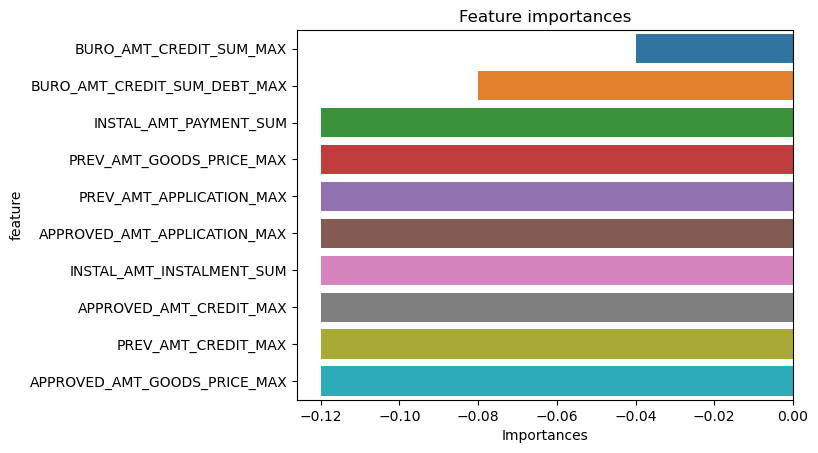

In [75]:
plt.title("Feature importances")
sns.barplot(x=feat_imp['score'], y=feat_imp['feature'])
plt.xlabel('Importances')
plt.show()

In [78]:
feat_imp.to_csv('feat.csv', index = False)

## lime

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [37]:
import lime
from lime import lime_tabular

In [38]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="classification",feature_names=X.columns.values.tolist(), verbose=True)

explainer

In [44]:
import random
idx = random.randint(1, len(X_test))



explanation = explainer.explain_instance(X_test.values[idx], model.predict_proba,
                                         num_features=15)

explanation.show_in_notebook()

2023/10/24 13:18:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '456fdaffe9a543a78a41fceee560b959', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 13:18:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6995571cce714938bb62455ee8cb8552', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Intercept 0.1858402958311446
Prediction_local [0.67927112]
Right: 0.7894736842105263


In [41]:
import shap
shap.initjs()

In [42]:
x_exple = shap.sample(X_train, 2)

In [76]:
shap_explainer = shap.KernelExplainer(model.predict_proba,x_exple )

In [77]:
shap_values = shap_explainer.shap_values(x_exple)
shap_values

  0%|          | 0/2 [00:00<?, ?it/s]

2023/10/24 15:25:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '52d2d184c9fa4a3c9c7fa0a33c6b081f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:25:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ac0090b1e7704966b79d7fe273c15a9e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:26:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6aef0b3c91d44a8d9cefdefd98f98510', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:26:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e810386627d74c8e88e0d6077dac6eba', which will track hyperparameters, performance metrics, model artifacts, and lineage i

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.00547854,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.0063981 ]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.00547854,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.0063981 ]])]

  0%|          | 0/2 [00:00<?, ?it/s]

2023/10/24 15:27:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3ae2e2d7859e4176a182bba586f4a8ec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:28:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb6802d992a34517a7b9d44b4b5f3e95', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:28:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '58fc246e41c64487873f0a2a417f6363', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:28:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3612c4909e884628a826b2c152b7e5d3', which will track hyperparameters, performance metrics, model artifacts, and lineage i

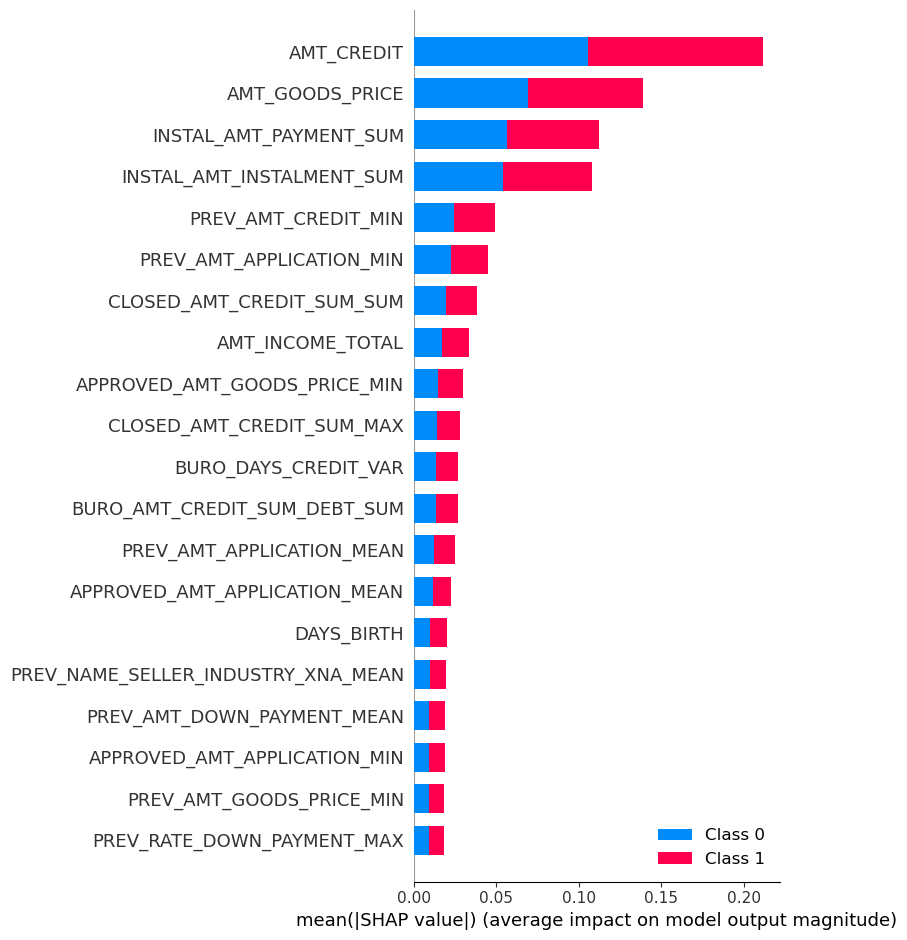

In [79]:
shap.summary_plot(shap_explainer.shap_values(x_exple),
                  feature_names=X.columns.values.tolist())

In [80]:
shap.force_plot(shap_explainer.expected_value[0],
                shap_explainer.shap_values(x_exple.values[0])[0],
                feature_names=X.columns.values.tolist(),
                out_names="defaut de credit")

2023/10/24 15:30:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bc341b77e7bf407189d89edbd385542c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:30:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f9da48fb026241238839cd7b3fd16c21', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/24 15:32:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '26d0f2cc08a7418d8075119286e9df61', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:32:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '711f4e24da2b4b938828eeaa7508c206', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


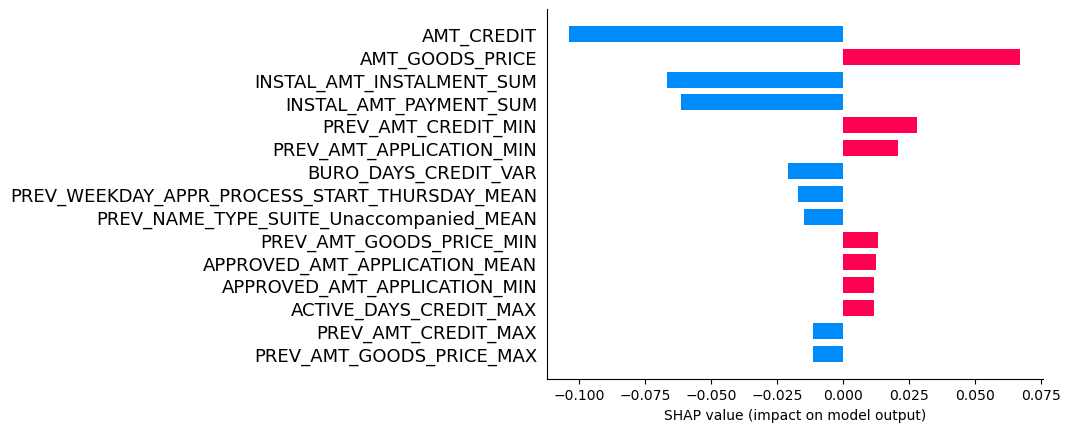

2023/10/24 15:32:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99c1c6bfa0c140689ff9f3087b76de57', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:33:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '611951d947184f32b0817935a52ca3e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


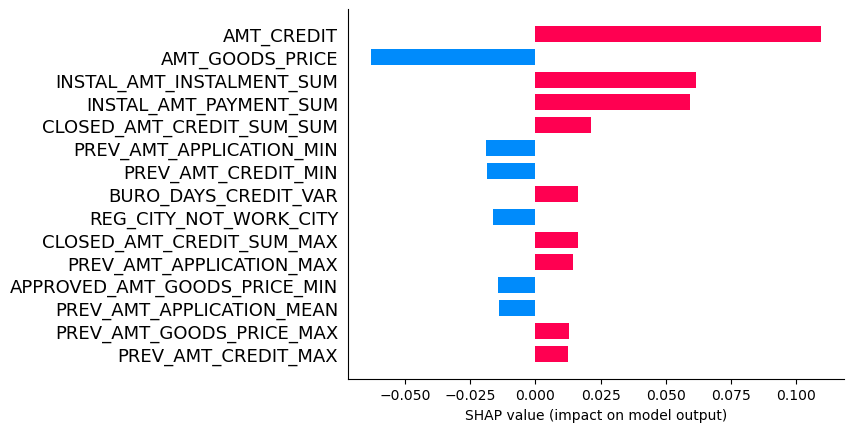

In [82]:
shap.bar_plot(shap_explainer.shap_values(x_exple.values[0])[1], feature_names=X.columns.values.tolist(), max_display=15)
shap.bar_plot(shap_explainer.shap_values(x_exple.values[0])[0], feature_names=X.columns.values.tolist(), max_display=15)

In [ ]:
data = data.drop(columns = 'index')
data

In [ ]:
import joblib


In [ ]:
joblib.dump(model,'model_pret.joblib')

In [ ]:
  data.to_csv('data.csv', index = False)